# NLP Project 1 _ Coronavirus Fake News

Analysis and processing of textual information

- Get data from text
- Topic detection
- Text classification

The purpose of this project is to discover characteristic features of fake news about Covid-19 using basic NLP tools. We will also see if it is possible to automatically classify fake news with machine learning methods. We will use the <i>corona_fake.csv</i> dataset. This dataset contains news in English about covid-19 tagged according to whether it is <i>fake</i> news or not. The dataset is organized into four columns: title, text, source, label.

We begin using a simple logistic regression model, trained only on the headlines, that reaches accuracy of 84% on the test set. We'll take advantage of the simplicity of the logistic regression model to infer what are the most informative features of fake news.

At the end we implement a more complex classifier, using a RNN with LSTM cells and a pretrained embedding layer (Glove). This model will be trained on the full bodies of the news. The accuracy of this model on the test set is comparable with the accuracy of the simpler logistic regression model and it takes much more time to train it. Moreover, being a deep learning model is opaque and we can't see what features the model uses to distinguish between fake and true news.

In [1]:
import nltk
nltk.download('all')
import pandas as pd
import numpy as np

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/lorenzovenieri/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/lorenzovenieri/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/lorenzovenieri/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/lorenzovenieri/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/lorenzovenieri/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-da

In [2]:
df= pd.read_csv("corona_fake.csv")

df.head()

,title,text,source,label
0,Due to the recent outbreak for the Coronavirus...,"You just need to add water, and the drugs and ...",coronavirusmedicalkit.com,Fake
1,NaN,Hydroxychloroquine has been shown to have a 10...,RudyGiuliani,Fake
2,NaN,Fact: Hydroxychloroquine has been shown to hav...,CharlieKirk,Fake
3,NaN,The Corona virus is a man made virus created i...,JoanneWrightForCongress,Fake
4,NaN,Doesn’t @BillGates finance research at the Wuh...,JoanneWrightForCongress,Fake


In [4]:
df.label.unique() #there are some instances of the dataframe with label 'fake' and not 'Fake'

array(['Fake', nan, 'TRUE'], dtype=object)

In [3]:
df['label'] = df['label'].replace(['fake'],'Fake')

## Obtaining data from texts

We'll create 2 datasets: df_fake and df_true

In [5]:
df_fake = df.loc[df['label'] == 'Fake']

df_fake.head()

,title,text,source,label
0,Due to the recent outbreak for the Coronavirus...,"You just need to add water, and the drugs and ...",coronavirusmedicalkit.com,Fake
1,NaN,Hydroxychloroquine has been shown to have a 10...,RudyGiuliani,Fake
2,NaN,Fact: Hydroxychloroquine has been shown to hav...,CharlieKirk,Fake
3,NaN,The Corona virus is a man made virus created i...,JoanneWrightForCongress,Fake
4,NaN,Doesn’t @BillGates finance research at the Wuh...,JoanneWrightForCongress,Fake


In [6]:
df_true = df.loc[df['label'] == 'TRUE']

df_true.head()

,title,text,source,label
9,Basic protective measures against the new coro...,Stay aware of the latest information on the CO...,https://www.who.int/emergencies/diseases/novel...,TRUE
14,Exposing yourself to the sun or to temperature...,"You can catch COVID-19, no matter how sunny or...",https://www.who.int/emergencies/diseases/novel...,TRUE
16,Being able to hold your breath for 10 seconds ...,The most common symptoms of COVID-19 are dry c...,https://www.who.int/emergencies/diseases/novel...,TRUE
17,Drinking alcohol does not protect you against ...,Frequent or excessive alcohol consumption can ...,https://www.who.int/emergencies/diseases/novel...,TRUE
18,COVID-19 virus can be transmitted in areas wit...,"From the evidence so far, the COVID-19 virus c...",https://www.who.int/emergencies/diseases/novel...,TRUE


## - Finding phrases

Phrases are multiword terms, that is, sequences of words that have an overall meaning significantly different from the meaning derived from the meanings of the individual words (e.g. New York has a different meaning than can be derived from New and York).

We'll compute the best bigrams and trigrams of the fake news headlines that are not in the real news headlines.



In [7]:
#Import the list of stopwords from nltk
stopwords = nltk.corpus.stopwords.words('english')
#Add some custom stopwords
stopwords = stopwords + ['unknown', 've', 'hadn', 'll', 'didn', 'isn', 'doesn', 'hasn' ]

In [8]:
from nltk import pos_tag, word_tokenize
from nltk.collocations import *
import re

In [9]:
help(nltk.collocations.BigramAssocMeasures)

Help on class BigramAssocMeasures in module nltk.metrics.association:

class BigramAssocMeasures(NgramAssocMeasures)
 |  A collection of bigram association measures. Each association measure
 |  is provided as a function with three arguments::
 |  
 |      bigram_score_fn(n_ii, (n_ix, n_xi), n_xx)
 |  
 |  The arguments constitute the marginals of a contingency table, counting
 |  the occurrences of particular events in a corpus. The letter i in the
 |  suffix refers to the appearance of the word in question, while x indicates
 |  the appearance of any word. Thus, for example:
 |  
 |  - n_ii counts ``(w1, w2)``, i.e. the bigram being scored
 |  - n_ix counts ``(w1, *)``
 |  - n_xi counts ``(*, w2)``
 |  - n_xx counts ``(*, *)``, i.e. any bigram
 |  
 |  This may be shown with respect to a contingency table::
 |  
 |              w1    ~w1
 |           ------ ------
 |       w2 | n_ii | n_oi | = n_xi
 |           ------ ------
 |      ~w2 | n_io | n_oo |
 |           ------ ------
 |  

1) We compute the tokens of the fake news headlines and abel these tokens by their PoS. (There are news without a headline and there may be headlines with words that have special characters at the beginning, if a news item does not have a headline (NaN in the 'title' column) we substitute NaN for 'empty')

In [37]:
#Substitute NaN with 'empty'
df_no_na = df.fillna('empty')

#dataframe of fake news
df_fake = df_no_na.loc[df['label'] == 'Fake']

#dataframe of true news
df_true = df_no_na.loc[df['label'] == 'TRUE']

#toss out empty headlines

titles_fake_noempty = [fh for fh in df_fake['title'].to_list() if fh != 'empty']
titles_true_noempty = [th for th in df_true['title'].to_list() if th != 'empty']

#create a text of all the titles Fake, all in lowercase

titles_fake = " ".join(titles_fake_noempty).lower()

#create a text of all the titles True, all in lowercase

titles_true = " ".join(titles_true_noempty).lower()

In [12]:
#titulares_fake and true are already lowercase
#filter the tokens starting with alphabetic character
tokens_titles_fake = [w for w in word_tokenize(titles_fake) if re.match("^[a-z]+.*", w)]
tokens_titles_true = [w for w in word_tokenize(titles_true) if re.match("^[a-z]+.*", w)]
#PoS labeling
tagged_tokens_fake = nltk.pos_tag(tokens_titles_true)
tagged_tokens_true = nltk.pos_tag(tokens_titles_true)

2) We compute the top 1000 bigrams and the top 1000 trigrams from the labeled tokens (e.g. [(Basic, JJ), ...]) of the false holders. We use the PMI metrics and the Likehood Ratio.

In [13]:
from nltk.util import ngrams

bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()

def good_stw_candidate(candidate):
    test = True
    if candidate[0][0] in stopwords or candidate[-1][0] in stopwords:
        test = False
    return test

def filter_collocation_candidates(candidates):
    #If we loaded a list of stopwords
    if len(stopwords) > 0:
         #build a list of candidates that are not stopwords
        col_candidates_filtered = [c for c in candidates if good_stw_candidate(c) == True]
    else:
        col_candidates_filtered = candidates
    return col_candidates_filtered

#get_n_best_candidates and filter for stopwords with the same function
def get_n_best_candidates_pmi(bigram_candidates, trigram_candidates, n_best_collocations):
    nbest_bigram_candidates = bigram_candidates.nbest(bigram_measures.pmi,n_best_collocations)
    nbest_trigram_candidates = trigram_candidates.nbest(trigram_measures.pmi,n_best_collocations)
    return filter_collocation_candidates(nbest_bigram_candidates), filter_collocation_candidates(nbest_trigram_candidates)

def get_n_best_candidates_lr(bigram_candidates, trigram_candidates, n_best_collocations):
    nbest_bigram_candidates = bigram_candidates.nbest(bigram_measures.likelihood_ratio,n_best_collocations)
    nbest_trigram_candidates = trigram_candidates.nbest(trigram_measures.likelihood_ratio,n_best_collocations)
    return filter_collocation_candidates(nbest_bigram_candidates), filter_collocation_candidates(nbest_trigram_candidates)


bigrams_titulares_fake_candidates=BigramCollocationFinder.from_words(tagged_tokens_fake)
bigrams_titulares_true_candidates=BigramCollocationFinder.from_words(tagged_tokens_true)
trigrams_titulares_fake_candidates=TrigramCollocationFinder.from_words(tagged_tokens_fake)
trigrams_titulares_true_candidates=TrigramCollocationFinder.from_words(tagged_tokens_true)

nbest_bigram_fake_pmi, nbest_trigram_fake_pmi = get_n_best_candidates_pmi(
    bigrams_titulares_fake_candidates, trigrams_titulares_fake_candidates,1000)
nbest_bigram_fake_lr, nbest_trigram_fake_lr = get_n_best_candidates_lr(
    bigrams_titulares_fake_candidates, trigrams_titulares_fake_candidates,1000)



In [14]:
len(nbest_bigram_fake_pmi)

751

In [15]:
len(nbest_bigram_fake_lr)

595

In [16]:
#doing the intersection we can see the distinctive features chosen by both metrics
set_pmi=set(nbest_bigram_fake_pmi)
set_lr=set(nbest_bigram_fake_lr)
intersection=set_pmi.intersection(set_lr)
print('The intersection set contains {} bigrams'.format(len(intersection))) 

#we can also see which bigrams are chosen by one metric and which are chosen by the other
pmi_only=set_pmi-set_lr
print(len(pmi_only))

lr_only=set_lr-set_pmi
print(len(lr_only))

The intersection set contains 554 bigrams
197
41


In [17]:
#let's see the lr_only bigrams
[b[0][0]+' '+b[1][0] for b in lr_only][:50]

['public health',
 'tracing help',
 'coronavirus disease',
 'dryers effective',
 'lung disease',
 'get sick',
 'disease drinking',
 'younger people',
 'coronavirus spread',
 'coronavirus came',
 'prevent infection',
 'novel coronavirus',
 'get tested',
 'higher risk',
 'really mean',
 'coronavirus vaccine',
 'potential coronavirus',
 'coronavirus epidemic',
 'coronavirus outbreak',
 'coronavirus compare',
 'new coronavirus',
 'severe illness',
 'older people',
 'getting sick',
 "n't know",
 'help prevent',
 'people also',
 'extra food',
 'causes covid-19',
 'health supplies',
 'global health',
 'outbreak like',
 'treating covid-19',
 'coronavirus disease',
 'coronavirus crisis',
 'get infected',
 'could contact',
 'outbreak could',
 'could help',
 'coronavirus disease',
 'health care']

In [18]:
#let's see the pmi_only bigrams
[b[0][0]+' '+b[1][0] for b in pmi_only]

['special risks',
 'come much',
 'pandemic turns',
 'women given',
 'warmer weather',
 'antibodies covid-19',
 'system play',
 'infecting others',
 'convalescent plasma',
 'protective measures',
 'lab uv',
 'pandemic automatically',
 'care providers',
 'many questions',
 'use soap',
 'lockdown scientists',
 'evidence supporting',
 'hot air',
 'public wash',
 'scientists quantify',
 'companies selling',
 'evidence points',
 'vaccine drug',
 'states infectious',
 'paper says',
 'preventing deaths',
 'community statement',
 'pandemic experiment',
 'become seriously',
 'transmitted via',
 'war conspiracy',
 'covid-19 spread',
 'older adults',
 'disinfect hands',
 'selling fraudulent',
 'heat kill',
 'outbreaks like',
 'approved treatments',
 'viral video',
 'get hired',
 'still come',
 'surfaces ventilator',
 'well visit',
 'pressure medicines',
 'health critically',
 'avoid exposure',
 'system strong',
 'keep infected',
 'someone blame',
 'grocery store',
 'food handled',
 'paper money',


In [19]:
#intersection bigrams
[b[0][0]+' '+b[1][0] for b in intersection][:50]

['theories flourish',
 'spreads chasing',
 'debunk fringe',
 'communications look',
 'human consumption',
 'summer heat',
 'nonurgent appointments',
 'antibiotics effective',
 'path germany',
 'virus outbreak',
 'diabetes considered',
 'grandkids school',
 'plasma therapy',
 'uv lamps',
 'fever/pollen allergy',
 'supply chain',
 'spreads many',
 'anti-vaxxers already',
 'offers financing',
 'selling sham',
 'accidentally released',
 'stay informed',
 'grandma still',
 'vaccination certificates',
 'parents often',
 'propagated viral',
 'non-outbreak area',
 'system act',
 'hay fever',
 'go away',
 'selling fake',
 'extremists around',
 'reach times',
 'ventilator vs.',
 'contain pshuttle-sn',
 'mutation turbocharge',
 'speed fuels',
 'experiment shows',
 'read different',
 'vaccine hesitancy',
 'regularly rinsing',
 'essential information',
 'trade measures',
 'drinking methanol',
 'shot increases',
 'disinfection lamp',
 'adding pepper',
 'must study',
 'create stigma',
 'clothes right

In [20]:
#trigrams
#doing the intersection we can see the distinctive features chosen by both metrics
set_pmi_tri=set(nbest_trigram_fake_pmi)
set_lr_tri=set(nbest_trigram_fake_lr)
intersection_tri=set_pmi_tri.intersection(set_lr_tri)
print('The intersection set contains {} bigrams'.format(len(intersection_tri))) 

The intersection set contains 64 bigrams


In [21]:
#let's see the lr_only trigrams
[b[0][0]+' '+b[1][0]+' '+b[2][0] for b in intersection_tri]

['people also susceptible',
 'contact tracing deliver',
 'keep extra food',
 'currently no drugs',
 'higher than degrees',
 'hand dryers effective',
 'far alex jones',
 'contact tracing help',
 'higher death rate',
 'lockdown scientists strongly',
 'skin thermal scanners',
 'alex jones ordered',
 'scientists strongly condemn',
 'health care workers',
 'chronic medical condition',
 'least so far',
 'certificates false claim',
 'celebrities no evidence',
 'eating garlic help',
 'false conspiracy theories',
 'flu shot stock',
 'false claim bill',
 'learned so far',
 'pregnant women given',
 'lung disease drinking',
 'care workers present',
 'nose with saline',
 'treatments alex jones',
 'difference between self-isolation',
 'conspiracy theories flourish',
 'strongly condemn rumors',
 'serologic antibody testing',
 'affect brain function',
 'flu shot increases',
 'quarantine vs. isolation',
 'younger people also',
 'rinsing your nose',
 'tracing help slow',
 'holding your breath',
 'otherw

- In the intersection sets there are all the bigrams and trigrams that are good for both metrics. We can see some bi/trigrams that can be easily associated with fake news ('anti-coronavirus toothpaste','bill gates planning', (maybe) 'wireless technology', ...) but overall they are very diluted between a lot of ngrams that can also be associated with true news.

- I can't really tell by the results obtained which metric is the best for our analysis, but from what I've read on the book (Foundations of Statistical Natural Language Processing (Manning & Schutze)) mutual information is a good measure of independence (values close to 0 indicate independence), but it is a bad measure of dependence because for dependence the score depends on the frequency of the individual words. Since we are mesuring pointwise mutual information to generate ngrams (words whose presence is not independent) pmi shouldn't be the wiser choice, so I would pick the likelihood ratio.

The most informative bigrams are the ones having the syntactic pattern of a noun phrase, in the cell below we can see how to filter those for bigrams.

In [22]:
#to filter bigrams by JJ+NN/NNS, NN+NN we can implement this function:
def PoS_filter_bigrams(tuple_list):
    filtered=[]
    for t in tuple_list:
        if (t[0][1]=='JJ' and (t[1][1]=='NN' or t[1][1]=='NNS')) or (t[0][1]=='NN' and t[1][1]=='NN'):
            filtered.append(t)
    return filtered
    
[b[0][0]+' '+b[1][0] for b in PoS_filter_bigrams(nbest_bigram_fake_lr)]

['new coronavirus',
 'social distancing',
 'natural origin',
 'novel coronavirus',
 'serologic antibody',
 'flu shot',
 'false claim',
 'public health',
 'grocery shopping',
 'garlic help',
 'alex jones',
 'death rate',
 'humid climates',
 'pregnant women',
 'pshuttle-sn sequence',
 'thermal scanners',
 'coronavirus vaccine',
 'brain function',
 'common cold',
 'vitamin c',
 'extended stay',
 'extraordinary race',
 'hot bath',
 'specific medicines',
 'immune system',
 'medical condition',
 'claim bill',
 'health care',
 'public places',
 'saline help',
 'affect brain',
 'immune system',
 'lung disease',
 'coronavirus epidemic',
 'extra food',
 'severe illness',
 'anti-coronavirus toothpaste',
 'anti-vaccine movement',
 'biocontainment room',
 'biological threats',
 'breathing problem',
 'calm carry',
 'cautious consider',
 'claiming silver',
 'cross-border travel',
 'cytokine storms',
 'dark web',
 'digital handshake',
 'disinfection lamp',
 'dr. anthony',
 'early herd',
 'eastern fran

## Word and phrases vectorization (Word2Vec)

In [23]:
import gensim
from gensim.models.phrases import Phraser
from gensim.models import Phrases

We will get 'coronavirus'-related terms in the fake news and 'coronavirus'-related terms in the real news. We'll use the semantic similarity calculation of a word2vec model.

1) We train a phrase detection model in a sentence. For training we use all the headlines and bodies (not empty) of the false and true news.We uss Gensim's Phraser module.

In [24]:
df= pd.concat([df_fake, df_true], axis=0, ignore_index=True)

text_stream = [word_tokenize(d.lower()) for d in df.title.tolist()+df.text.tolist() 
               if word_tokenize(d.lower())!=[] ]
phrases = Phrases(text_stream, min_count=1, threshold=2, delimiter=' ')

2) We transform each phrase of the fake news in a list of phrases lemmatized.


In [26]:
def good_stw_candidate(t):
    v = False
    #If it's composed by more than one word
    if ' ' in t:
        tl = t.split(' ') #list of tokens
        #If the first and last tokens are alphabetic and not stopwords
        if re.match("^[a-z]+.*", tl[0]) and re.match("^[a-z]+.*", tl[-1]) and \
           tl[0] not in stopwords and tl[1] not in stopwords:
            v = True
    #If it's composed by only one word
    else:
        #If it's alphabetic and not a stopword
        if t not in stopwords and re.match("^[a-z]+.*", t):
            v = True
    return v

In [27]:
#Import the NLTK lemmatizer
from nltk.stem.wordnet import WordNetLemmatizer


#To obtain the lemma, the term must have a PoS tag. The format of the Wordnet PoS tag is different from the
#tag of the PoS tagger of NLTK

def get_wn_pos(pos): #translate PoS tagger format to Wordnet format
    if re.match(r'^N',pos):
        wn_pos = 'n'
    elif re.match(r'^V',pos):
        wn_pos = 'v'
    else:
        wn_pos = 'n'
    return wn_pos

def wnlemmatize(t,postag): #lemmatizes a term with a PoS tag using Wordnet
    lemma = ""
    lem = WordNetLemmatizer() #create a lemmatizer
    #If the candidate is a single word, get the lemma with the Wordnet lemmatizer according to its PoS
    if ' ' not in t:
        lemma = lem.lemmatize(t,get_wn_pos(postag[0][1]))
    #If the candidate is a multiword, get the lemma as if it were a name, applying the lemmatizer of WordNet
    else:
        lemma = lem.lemmatize(t,'n')
    return lemma

In [28]:
df_fake = df.loc[df['label'] == 'Fake']

postag={}

def transform_sentence(doc):
    doc_tokens = word_tokenize(doc.lower()) #tokenize the sentence
    text_phrases = phrases[doc_tokens] #get the phrases
    #Toss out punctuation from the phrases in the titles
    phrases_stripped = [tp.strip('".,;:-():!?-‘’ ') for tp in text_phrases]
    #remove the empty strings
    phrases_stripped = [t for t in phrases_stripped if t!='']
    #filter for stw_goodcandidates
    phrases_no_stw = [tp for tp in phrases_stripped if good_stw_candidate(tp) == True]
    #PoS labeling of the phrases, store them in the postag dict
    for ps in phrases_no_stw:
        postag[ps] = nltk.pos_tag(word_tokenize(ps))
    #lemmatize phrases with Wordnet
    phrases_lemmatized = [wnlemmatize(ps,postag[ps]) for ps in phrases_no_stw]    
    return phrases_lemmatized

sentence_stream = df_fake.title.tolist() + df_fake.text.tolist()
transformed_sentences = [transform_sentence(ss) for ss in sentence_stream]


print(transformed_sentences[:50])

[['recent outbreak', 'covid-19', 'health organization', 'give', 'away', 'vaccine', 'kit', 'pay', 'shipping'], ['empty'], ['empty'], ['empty'], ['empty'], ['empty'], ['empty'], ['empty'], ['empty'], ['empty'], ['empty'], ['empty'], ['empty'], ['empty'], ['empty'], ['empty'], ['empty'], ['china', 'seek', 'court', 'approval', 'coronavirus patients'], ['empty'], ['coronavirus originate', 'chinese government', 'laboratory', 'scientists believe', 'killer', 'disease', 'begin', 'research facility', 'wet', 'fish market'], ['empty'], ['coronavirus outbreak', 'criminal', 'preplanned action'], ['people learned', 'coincidence'], ['empty'], ['empty'], ['empty'], ['empty'], ['empty'], ['empty'], ['empty'], ['covid', 'terror', 'uncertainty'], ['covid-19', 'certain', 'state', 'state', 'control'], ['empty'], ['empty'], ['empty'], ['covid-19', 'climate alarmists', 'fear', 'is…'], ['empty'], ['empty'], ['empty'], ['empty'], ['southern', 'europe', 'slave market'], ['coronavirus', 'reactionary', 'usa'], ['e

3) We build a Word2Vec model of the titles and bodies of fake news

In [29]:
w2vnyt = gensim.models.Word2Vec(
        transformed_sentences,
        vector_size=150, # size of the vectors in the model
        window=10, # size of the context window 
        min_count= 3, # minimum number of times a word must appear to be included in the model
        workers= 1, # number of worker threads to use when training the model
        seed=1 
)

w2vnyt.train(transformed_sentences, total_examples=len(transformed_sentences), epochs=10)

(897019, 1172630)

4) Select the vocabulary of the word2vec model on which the similar terms will be seen

In [33]:
phrases_vocabulary = list(w2vnyt.wv.key_to_index)

#list of PoS tags that cannot be the initial or final token of a term
no_pos_in = ['DT', 'IN', 'PRP', 'CC', 'CD','MD', 'VBG', 'VBD', 'RP', 'RB'] 

def good_candidate(t,postag):
    v = False
    #If it's composed by more than one word
    if ' ' in t:
        tl = t.split(' ') # list of tokens
        #If the first and last tokens are alphabetic and not stopwords
        if re.match("^[a-z]+.*", tl[0]) and re.match("^[a-z]+.*", tl[-1]) and \
            tl[0] not in stopwords and tl[1] not in stopwords:
            # and its PoS tag is not in the no_pos_in list
            if postag[0][1] not in no_pos_in and postag[-1][1] not in no_pos_in:
                v = True
    #If it's composed by only one word 
    else:
        #If it's alphabetic and not a stopword
        if t not in stopwords and re.match("^[a-z]+.*", t):
            # and its PoS tag is not in the no_pos_in list
            if postag[0][1] not in no_pos_in:
                v = True
    return v

def phrase_is_term(phrase): #checks if a phrase is a term
    test = False
    if phrase not in postag: 
        pos = nltk.pos_tag(word_tokenize(phrase)) 
    else:
        pos = postag[phrase]
    if good_candidate(phrase,pos):
        test = True
    return test

terms_vocabulary = [pv for pv in phrases_vocabulary if phrase_is_term(pv) == True]

print(terms_vocabulary[:50])


['coronavirus', 'china', 'virus', 'covid-19', 'people', 'vaccine', 'state', 'say', 'vitamin c', 'time', 'include', 'disease', 'use', 'pandemic', 'wuhan', 'bill gates', 'death', 'government', 'u', 'research', 'case', 'infection', 'make', 'system', 'report', 'sars', 'get', 'work', 'flu', 'lab', 'human', 'year', 'many', 'control', 'study', 'medium', 'take', 'health', 'country', 'world', 'see', 'new', 'cause', 'test', 'hospital', 'accord', 'c', 'patient', 'day', 'laboratory']


5) Let's visualize the tems (from fake news) semantically closest to 'coronavirus'

Considering the terms as feature names, the feature name-distance relationship is expressed as a tuple.  
The first element of the tuple is the feature name and the second element is its distance value to a term of reference according to #Word2Vec. These tuples are placed in a list (w2v_tuples) so that later can be ordered from closest to least close

In [35]:
term = 'coronavirus'

w2v_tuples = []

feature_names = terms_vocabulary

#For each feature name, we calculate its distance with the reference term using the model.similarity method.
#If the distance is bigger than 0, the tuple is put in the list of tuples
for i in range(0, len(feature_names)):
    if feature_names[i] != term and w2vnyt.wv.similarity(term, feature_names[i]) > 0:
        w2v_tuples.append((feature_names[i], w2vnyt.wv.similarity(term, feature_names[i])))
    
#We sort the list of tuples by the distance
w2v_sorted_tuples = sorted(w2v_tuples, key=lambda tup: tup[1])

#print(w2v_sorted_tuples)

labels = ['Term', 'Distance_fake']

#we create a dataframe from which we will build the table
df4 = pd.DataFrame.from_records(w2v_sorted_tuples, columns=labels)

#Construction and visualization of the table
print ("")
print ("Distancia respecto al término", term) 
print ("")

print (df4)


Distancia respecto al término coronavirus

                       Term  Distance_fake
0                      gate       0.008447
1        roseland community       0.035509
2                government       0.043602
3     investigational drugs       0.048055
4                      take       0.050527
...                     ...            ...
6543     natural reservoirs       0.935428
6544         horseshoe bats       0.945813
6545     deadliest diseases       0.946683
6546         h5n1 influenza       0.949906
6547          includes sars       0.953583

[6548 rows x 2 columns]


6) We do the same for true news

In [38]:
postag={}
sentence_stream_true=df_true.title.tolist()+df_true.text.tolist()
transformed_sentences_true = [transform_sentence(ss) for ss in sentence_stream_true]

w2vnyt_true = gensim.models.Word2Vec(
        transformed_sentences_true,
        vector_size=150, # size of the vectors in the model
        window=10, #context window size
        min_count= 3, # minimum number of times a word must appear to be included in the model
        workers= 1, # number of worker threads to use when training the model
        seed=1 
)

w2vnyt_true.train(transformed_sentences_true, total_examples=len(transformed_sentences_true), epochs=10)

phrases_vocabulary_true = list(w2vnyt_true.wv.key_to_index)

term = 'coronavirus'

w2v_true_tuples = []

feature_names_true = phrases_vocabulary_true

#For each feature name, we calculate its distance with the reference term using the model.similarity method.
for i in range(0, len(feature_names_true)):
    if feature_names_true[i] != term and w2vnyt_true.wv.similarity(term, feature_names_true[i]) > 0:
        w2v_true_tuples.append((feature_names_true[i], w2vnyt_true.wv.similarity(term, feature_names_true[i])))

#We sort the list of tuples by the distance
w2v_true_sorted_tuples = sorted(w2v_true_tuples, key=lambda tup: tup[1])

#print(w2v_true_sorted_tuples)

labels = ['Term', 'Distance_true']

#we create a dataframe from which we will build the table
df5 = pd.DataFrame.from_records(w2v_true_sorted_tuples, columns=labels)

#Construction and visualization of the table
print ("")
print ("Distancia respecto al término", term) 
print ("")

print (df5)


Distancia respecto al término coronavirus

                      Term  Distance_true
0              cause death       0.050547
1                  vaccine       0.091737
2        develops symptoms       0.135857
3     severe complications       0.150809
4                      use       0.208946
...                    ...            ...
5578               frieman       0.971916
5579           common cold       0.972364
5580                rarely       0.977768
5581          severe viral       0.983238
5582                 cause       0.993837

[5583 rows x 2 columns]


In [39]:
df4.head(10)

,Term,Distance_fake
0,gate,0.008447
1,roseland community,0.035509
2,government,0.043602
3,investigational drugs,0.048055
4,take,0.050527
5,system,0.054600
6,u,0.057408
7,bad news,0.063913
8,control,0.071339
9,docuseries,0.076788


In [40]:
df5.head(10)

,Term,Distance_true
0,cause death,0.050547
1,vaccine,0.091737
2,develops symptoms,0.135857
3,severe complications,0.150809
4,use,0.208946
5,meter,0.224472
6,fast-tracking,0.230735
7,diagnostic,0.237897
8,marston,0.239012
9,hand,0.257027


In the cell below we can see the terms ordered by how much their distance with the term 'coronavirus' differs from the fake news set and the true news set. More difference means that the term is interestingly more representative of one of the two classes. 

One thing that is noticeable is how much the words related to the Bill & Melinda Gates Foundation (the term 'gate' may be the lemmatization of 'Gates')) are closer to 'coronavirus' in the fake news set compared to the true news. This gets along with our experience since there are a lot of conspiracy theories about the Gates foundation and Coronavirus.

In [41]:
df6=df4.merge(df5,on='Term')
df6['Difference']=abs(df6['Distance_true']-df6['Distance_fake'])
df6.sort_values(by='Difference', ascending=False, inplace=True)
df6.head(50)

,Term,Distance_fake,Distance_true,Difference
5,bad news,0.063913,0.863050,0.799137
0,gate,0.008447,0.666269,0.657822
9,people,0.092993,0.739906,0.646913
6,control,0.071339,0.697567,0.626229
13,chose,0.151664,0.726912,0.575248
3,system,0.054600,0.626957,0.572358
21,world,0.213319,0.767957,0.554638
14,much lower,0.156879,0.705466,0.548587
10,power,0.110879,0.658943,0.548064
7,foundation,0.082848,0.616305,0.533456


# Topic detection

In [42]:
from nltk.corpus import wordnet as wn

We'll check if the fake news contains terms that are semantically distant from the meaning of the term 'disease' in Wordnet, by calculating the Wu and Palmer similarity between the wordnet sense 'disease.n.01' and the terms related to 'coronavirus' in the word2vec model of fake news.

1) We calculate the Wu and Palmer distance between the sense 'disease.n.01' and the first sense of the nouns most closely related to 'coronavirus' in the word2vec model of fake news.

In [43]:
for i in range(50):
    term=df4.Term.iloc[i]
    try:
        term=term.strip().replace(' ', '_')
        sense_term=wn.synset(term+'.n.01')
        print("Wu and Palmer distance between '{}' and 'disease(n.01)': ".format(term),
            sense_term.wup_similarity(wn.synset('disease.n.01')))
    except: 
        print("The term '{}' is not in WordNet ".format(term))

Wu and Palmer distance between 'gate' and 'disease(n.01)':  0.1
The term 'roseland_community' is not in WordNet 
Wu and Palmer distance between 'government' and 'disease(n.01)':  0.23529411764705882
The term 'investigational_drugs' is not in WordNet 
Wu and Palmer distance between 'take' and 'disease(n.01)':  0.2
Wu and Palmer distance between 'system' and 'disease(n.01)':  0.11764705882352941
Wu and Palmer distance between 'u' and 'disease(n.01)':  0.18181818181818182
The term 'bad_news' is not in WordNet 
Wu and Palmer distance between 'control' and 'disease(n.01)':  0.375
The term 'docuseries' is not in WordNet 
The term 'non-profit' is not in WordNet 
Wu and Palmer distance between 'foundation' and 'disease(n.01)':  0.2857142857142857
Wu and Palmer distance between 'vaccine' and 'disease(n.01)':  0.11764705882352941
Wu and Palmer distance between 'people' and 'disease(n.01)':  0.2857142857142857
Wu and Palmer distance between 'salvation' and 'disease(n.01)':  0.2222222222222222
Wu 

The Wu and Palmer similarity is a score from from 0 (more similar) to 1 (less similar).
We can see that a lot of the terms that are semantically close to 'coronavirus' in the fake news set have a score really low when measuring the similarity with the synset "disease.n.01", that should be higher considering that 'coronavirus' is a disease. A lot of this terms are also missing from Wordnet.

The reason for this may be that Wordnet needs constatly to be updated with new terms, with all the new semantic relations. For this reason I don't think that it is a good resource to analyze news about covid-19, that is a quite recent topic.

# Classification

We build an automatic binary classifier between true and fake news

In [44]:
df= pd.read_csv("corona_fake.csv")
df.label = df.label.replace(['fake'],'Fake')
#we fill the missing values (insted of dropping) because the info of "there is no title or text"
#could be useful to detect fake news
df['title']=df.title.fillna('NoTitle')
df['text']=df.text.fillna('NoText')
df.dropna(subset=['label'], inplace=True)
df.head()

,title,text,source,label
0,Due to the recent outbreak for the Coronavirus...,"You just need to add water, and the drugs and ...",coronavirusmedicalkit.com,Fake
1,NoTitle,Hydroxychloroquine has been shown to have a 10...,RudyGiuliani,Fake
2,NoTitle,Fact: Hydroxychloroquine has been shown to hav...,CharlieKirk,Fake
3,NoTitle,The Corona virus is a man made virus created i...,JoanneWrightForCongress,Fake
4,NoTitle,Doesn’t @BillGates finance research at the Wuh...,JoanneWrightForCongress,Fake


In [46]:
X = df.title.values #we use the title as the feature
y = df.label.values #we use the label as the target

In [47]:
#vectorize the titles suing TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

#we set lowercase=False because capital letters may be a distinctive element of the classes
tfidf_vectorizer = TfidfVectorizer(stop_words='english', lowercase=False)
X_tfidf = tfidf_vectorizer.fit_transform(X)

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf.A, y, test_size=0.33, random_state=1)

In [50]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [51]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [52]:
#predictions and evaluation

from sklearn.metrics import accuracy_score 

pred = lr.predict(X_test)
# Let's see how the model performs on the test set
score = accuracy_score(y_test, pred)
print('The accuracy score on the test set is: {}'.format(score))

The accuracy score on the test set is: 0.8407310704960835


In [53]:
#let's inspect the most informative words for the model

class_labels = lr.classes_

feature_names = tfidf_vectorizer.get_feature_names()

# Zip the feature names together with the coefficient array and sort by weights: feat_with_weights
feat_with_weights = sorted(zip(lr.coef_[0], feature_names))

print(class_labels[0]) 
for f in feat_with_weights[:20]:
    print(f)
    
print('')

print(class_labels[1]) 
for f in feat_with_weights[-20:]:
    print(f)

Fake
(-0.8280698971999038, 'NoTitle')
(-0.5341399179348005, 'Vitamin')
(-0.4128925346426516, 'Update')
(-0.3288142420480259, '5G')
(-0.30132923982040827, 'bioweapon')
(-0.299866574540067, 'Word')
(-0.23802049868823077, 'Behind')
(-0.21299674254185005, 'Wuhan')
(-0.20278850293745967, 'caused')
(-0.18952930248806424, 'Treatment')
(-0.1877335854993494, 'CORONAVIRUS')
(-0.18623578147314312, 'The')
(-0.18221589243817743, 'Cheap')
(-0.18219215200947916, 'Plandemic')
(-0.1814283832637579, 'Nutritional')
(-0.18056431366271247, 'Piracy')
(-0.17984690657501196, 'United')
(-0.17984690657501035, 'States')
(-0.16794374856849092, 'Made')
(-0.16584020929532958, 'consuming')

TRUE
(0.1696355508460357, 'originated')
(0.17674354625864708, 'Should')
(0.1779352544051644, 'Pandemic')
(0.17916062741181765, 'consumption')
(0.17940054686631635, 'Symptoms')
(0.1819818601051003, 'know')
(0.18218565343116452, 'When')
(0.1828711453304146, 'virus')
(0.1995257121715009, 'disease')
(0.2203316996138784, 'Safe')
(0.22

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


The most informative feature of the titles of fake news is its absence ('NoTitle' has weight -0.8178656394286765). 

Also the word "CORONAVIRUS" when written all in uppercase is distinctive of the fake news, while in the the true news it is written as 'Coronavirus' or 'coronavirus'.

There also can be found other terms that are related to conspiracy theories or pseudoscience in the fake news most informative words as '5G', 'Vitamin' or 'bioweapon'.

# LSTM classifier

We will build a more complex binary classifier, compsed by an embedding layer (weights taken from Glove), a LSTM layer with 300 units and at the end a fully connected layer, with output dimension = 2 (True/Fake).


In [88]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import string

In [58]:
df_no_na.sample(10)

,title,text,source,label
212,Piracy everywhere and pandemic for all,The crisis originated less in a miserable anim...,http://www.egaliteetreconciliation.fr,Fake
597,Scams related to COVID-19,COVID-19: Commission and national consumer aut...,https://ec.europa.eu/,TRUE
255,"I do not believe this is accidental"": expert o...",Topical comments on the state of the Chinese e...,https://sputnik.by/,Fake
776,That ‘Miracle Cure’ You Saw on Facebook? It Wo...,"Gargling warm salty water, taking vitamins or ...",https://www.nytimes.com/,TRUE
694,"The COVID-19 pandemic could last for 2 years, ...",A new report from researchers at the Center fo...,https://www.weforum.org/,TRUE
1106,How does soap kill coronavirus? If I don’t hav...,"Yes, you can use soap and water on surfaces ju...",https://www.cnn.com/,TRUE
67,empty,"The patented nanosilver we have, the Pentagon ...",infowars.com,Fake
774,Viral video mixes truth about COVID-19 with a ...,Runny nose and sputum are indeed symptoms of t...,https://healthfeedback.org/,TRUE
840,What are super spreaders and how can they affe...,Rather than using the term super spreaders (a ...,https://www.globalhealthnow.org/,TRUE
1027,How long does coronavirus live on surfaces?,Which surfaces are the most infectious and how...,https://www.nbcnews.com/,TRUE


In [62]:
df_no_na.title[0]

'Due to the recent outbreak for the Coronavirus (COVID-19) the World Health Organization is giving away vaccine kits. Just pay $4.95 for shipping'

In [61]:
df_no_na.text[0]

'You just need to add water, and the drugs and vaccines are ready to be administered. There are two parts to the kit: one holds pellets containing the chemical machinery that synthesises the end product, and the other holds pellets containing instructions that telll the drug which compound to create. Mix two parts together in a chosen combination, add water, and the treatment is ready.'

In [74]:
titles = df_no_na.title.tolist()
texts = df_no_na.text.tolist()
labels = df_no_na.label.tolist()



In [83]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
print(integer_encoded)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

[0 0 0 ... 1 1 1]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [85]:

# Toss out punctuation
data = [s.translate(str.maketrans('', '', string.punctuation)) for s in texts]

# Convert to lower case
for i in range(len(data)):
    data[i] = data[i].lower()

print(data[:10])

['you just need to add water and the drugs and vaccines are ready to be administered there are two parts to the kit one holds pellets containing the chemical machinery that synthesises the end product and the other holds pellets containing instructions that telll the drug which compound to create mix two parts together in a chosen combination add water and the treatment is ready', 'hydroxychloroquine has been shown to have a 100 effective rate treating covid19 yet democrat gretchen whitmer is threatening doctors who prescribe it if trump is for something democrats are against it they are okay with people dying if it means opposing trump', 'fact hydroxychloroquine has been shown to have a 100 effective rate treating covid19 yet democrat gretchen whitmer is threatening doctors who prescribe it if trump is for something democrats are against it they are okay with people dying if it means opposing trump sick', 'the corona virus is a man made virus created in a wuhan laboratory ask billgate

In [89]:
def tokenization(sentences):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    return tokenizer

data_tokenizer = tokenization(data)

vocab_size = len(data_tokenizer.word_index) + 1

print('Vocabulary Size: %d' % vocab_size)


Vocabulary Size: 37299


In [94]:
embeddings_index = {}
glove_path = 'glove.42B.300d.txt'
f = open(glove_path)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print(len(embeddings_index))

1917494


In [95]:
embedding_matrix = np.zeros((len(data_tokenizer.word_index) + 1, 300))
for word, i in data_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [96]:
embedding_matrix.shape

(37299, 300)

In [97]:
#define the embedding layer

embedding_vec_length = 300
max_len = max([len(x.split()) for x in data])

embedding_layer = Embedding(len(data_tokenizer.word_index) + 1,
                            embedding_vec_length,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False,
                            mask_zero=True)

In [99]:
max_len

5184

In [100]:
#we use just the bodies as features
X_train, X_test, y_train, y_test = train_test_split(data, onehot_encoded, test_size=0.2, random_state=1)

In [106]:
def encode_sequences(tokenizer, length, lines):
    # encode the sequences with word indexes
    seq = tokenizer.texts_to_sequences(lines)
    # padding
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

X_train = encode_sequences(data_tokenizer, max_len, X_train)
X_test = encode_sequences(data_tokenizer, max_len, X_test)

In [107]:
X_train.shape

(927, 5184)

In [108]:
units = 300

def build_model_classification(num_classes):
    model = Sequential()
    model.add(embedding_layer)
    model.add(LSTM(units))
    model.add(Dense(num_classes, activation='softmax'))
    return model

cl_model = build_model_classification(2)

In [109]:
cl_model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])

In [111]:
filename = 'cl_model' #file name to save the model

#ModelCheckpoint saves the model with the best validation loss (best epoch)

checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

cl_model.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.2, callbacks=[checkpoint], verbose=1)


Epoch 1/2
24/24 [==============================] - 773s 32s/step - loss: 0.6415 - accuracy: 0.6329 - val_loss: 0.5655 - val_accuracy: 0.6989

Epoch 00001: val_loss improved from inf to 0.56552, saving model to cl_model


INFO:tensorflow:Assets written to: cl_model/assets


INFO:tensorflow:Assets written to: cl_model/assets


Epoch 2/2
24/24 [==============================] - 715s 30s/step - loss: 0.4785 - accuracy: 0.7787 - val_loss: 0.4851 - val_accuracy: 0.7688

Epoch 00002: val_loss improved from 0.56552 to 0.48507, saving model to cl_model


INFO:tensorflow:Assets written to: cl_model/assets


INFO:tensorflow:Assets written to: cl_model/assets


In [113]:
cl_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, callbacks=[checkpoint], verbose=1)


Epoch 1/5
24/24 [==============================] - 737s 31s/step - loss: 0.3511 - accuracy: 0.8529 - val_loss: 0.5441 - val_accuracy: 0.7634

Epoch 00001: val_loss did not improve from 0.48507
Epoch 2/5
24/24 [==============================] - 710s 30s/step - loss: 0.3504 - accuracy: 0.8516 - val_loss: 0.5578 - val_accuracy: 0.7688

Epoch 00002: val_loss did not improve from 0.48507
Epoch 3/5
24/24 [==============================] - 754s 32s/step - loss: 0.2426 - accuracy: 0.8920 - val_loss: 0.4880 - val_accuracy: 0.8226

Epoch 00003: val_loss did not improve from 0.48507
Epoch 4/5
24/24 [==============================] - 854s 36s/step - loss: 0.1841 - accuracy: 0.9258 - val_loss: 0.4819 - val_accuracy: 0.8280

Epoch 00004: val_loss improved from 0.48507 to 0.48186, saving model to cl_model


INFO:tensorflow:Assets written to: cl_model/assets


INFO:tensorflow:Assets written to: cl_model/assets


Epoch 5/5
24/24 [==============================] - 762s 32s/step - loss: 0.1438 - accuracy: 0.9541 - val_loss: 0.5147 - val_accuracy: 0.7957

Epoch 00005: val_loss did not improve from 0.48186


In [114]:
from sklearn.metrics import classification_report, confusion_matrix

cl_model = load_model('cl_model')

In [115]:
y_pred = cl_model.predict(X_test)
class_predicted = np.where(y_pred > 0.5, 1,0)
print(classification_report(y_test, class_predicted))

              precision    recall  f1-score   support

           0       0.94      0.67      0.78       117
           1       0.74      0.96      0.83       115

   micro avg       0.81      0.81      0.81       232
   macro avg       0.84      0.81      0.81       232
weighted avg       0.84      0.81      0.81       232
 samples avg       0.81      0.81      0.81       232



In [116]:
cl_model.evaluate(X_test, y_test)

8/8 [==============================] - 87s 11s/step - loss: 0.5422 - accuracy: 0.8103


[0.542235791683197, 0.8103448152542114]

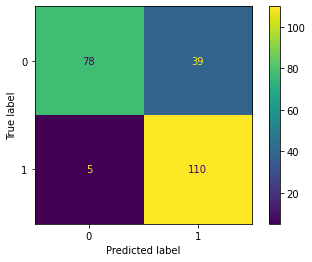

In [117]:
from sklearn.metrics import ConfusionMatrixDisplay

Ytest_int = np.argmax(y_test, axis=1)
class_pred_int=np.argmax(class_predicted,axis=1)
ConfusionMatrixDisplay.from_predictions(Ytest_int, class_pred_int)